# 准备

In [1]:
import time
import math
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%pylab inline

# 读取数据：原始用户操作数据
df_user_actions = pd.read_csv('./data/mars_tianchi_user_actions.csv', 
                              header = None, 
                              names = ('user_id', 'song_id', 'gmt_create', 'action_type', 'Ds'))
# 读取数据：原始歌曲信息数据
df_song_info = pd.read_csv('./data/mars_tianchi_songs.csv', 
                           header = None, 
                           names = ('song_id', 'artist_id', 'public_time','popular', 'language', 'gender'))
# 读取数据：按照艺人，统计每天的歌曲数据
df_song_by_artist = pd.read_csv('./data/songs_by_artist.csv', 
                             header = None, 
                             names = ['date', 'play', 'download', 'like', 'artist_id'])
df_song_by_artist['date'] = df_song_by_artist['date'].apply(lambda x: int(x.replace('-', '')))

# 从字符串类型的“年月日”格式日起中获取星期
def get_wday_from_date(time_value):
    return datetime.datetime.strptime(str(time_value),'%Y%m%d').weekday()+1
# 对按照艺人统计的数据，增加“星期”特征列
df_song_by_artist['w_day'] = df_song_by_artist['date'].apply(get_wday_from_date)

# 构造艺人ID列表
artist_id = list(set(df_song_by_artist['artist_id']))
# 构造艺人所属的歌曲的ID字典
artists = {}
for i in range(0, df_song_info.shape[0]):
    artist = df_song_info.iloc[i]['artist_id']
    song = df_song_info.iloc[i]['song_id']
    if artist not in artists:
        artists[artist] = []
    artists[artist].append(song)
# 构造结果文件中的日期Series
dates_future = pd.date_range('20150901', '20151030')
dates_past = pd.date_range('20150301', '20150830')

artist_V = ['8fb3cef29f2c266af4c9ecef3b780e97', 'c026b84e8f23a7741d9b670e3d8973f0',
            'c5f0170f87a2fbb17bf65dc858c745e2', '03c6699ea836decbc5c8fc2dbae7bd3b', 
            '4b8eb68442432c242e9242be040bacf9', '2e14d32266ee6b4678595f8f50c369ac']
artist_noV = [i for i in artist_id if i not in artist_V]

Populating the interactive namespace from numpy and matplotlib


**评测函数**

![score function](https://img.alicdn.com/tps/TB12LRiMXXXXXbKaXXXXXXXXXXX-801-341.png)

In [51]:
def score_fuc(date_from, date_to, file_predict, file_origin = './data/songs_by_artist.csv'):
    df_origin = pd.read_csv(file_origin, 
                             header = None, 
                             names = ['date', 'play', 'download', 'like', 'artist_id'])
    df_origin['date'] = df_origin['date'].apply(lambda x:int(x[:4]+x[5:7]+x[8:]))
    df_predict = pd.read_csv(file_predict, 
                             header = None, 
                             names = ['artist_id', 'play', 'date'])
    artist_list = list(set(df_predict['artist_id']))
    F = 0
    for artist in artist_list:
        variance = 0
        weight = 0
        data_origin = df_origin[(df_origin.artist_id == artist) ]
        data_predict = df_predict[df_predict.artist_id == artist]
        data_origin = data_origin[(data_origin.date >= date_from)
                                & (data_origin.date <= date_to)]
        print data_origin         
        print data_predict
        S = []
        T = []
        for i in range(len(data_predict)):
            S.append(data_predict.iloc[i]['play'])
            T.append(int(data_origin[data_origin.date == data_predict.iloc[i]['date']]['play']))
        print S
        print T
        for s,t in zip(S, T):
            weight += t
            variance += (((s-t)/t) * ((s-t)/t))
        weight = math.sqrt(weight)
        variance = math.sqrt(variance/len(data_predict))
        F += (1 - variance) * weight
    return F  

In [54]:
dates = pd.date_range('20150829', '20150830')
for artist in artist_id:
    data = df_song_by_artist[df_song_by_artist['artist_id'] == artist][-7:-2]
    data_mean = data.mean(axis = 0)
    data_mean_play = data_mean['play']
    temp = pd.DataFrame(data={'artist_id':artist, 'play':int(data_mean_play)}, 
                        index=dates)
    temp['date'] = dates
    temp.to_csv('./output/try_predict_last_week.csv', mode = 'a', encoding='utf-8',
                date_format = "%Y%m%d", index = False,header = False)

In [55]:
f = score_fuc(20150829, 20150830, './output/try_predict_last_week.csv')

         date  play  download  like                         artist_id
181  20150829    58         9     5  e087f8842fe66efa5ccee42ff791e0ca
182  20150830    77         8     0  e087f8842fe66efa5ccee42ff791e0ca
                          artist_id  play      date
0  e087f8842fe66efa5ccee42ff791e0ca    75  20150829
1  e087f8842fe66efa5ccee42ff791e0ca    75  20150830
[75, 75]
[58, 77]
         date  play  download  like                         artist_id
364  20150829   788        81     3  3e395c6b799d3d8cb7cd501b4503b536
365  20150830  1020       104     7  3e395c6b799d3d8cb7cd501b4503b536
                          artist_id  play      date
2  3e395c6b799d3d8cb7cd501b4503b536   936  20150829
3  3e395c6b799d3d8cb7cd501b4503b536   936  20150830
[936, 936]
[788, 1020]
         date  play  download  like                         artist_id
547  20150829   749        89    14  8da51d03b8b8717431e8b902856fb45e
548  20150830   726       112     8  8da51d03b8b8717431e8b902856fb45e
                 

In [56]:
f

1066.867744264954

**星期统计**

- 按照单个歌手，分析每星期的播放数据

In [2]:

# 统计每个星期对应的总播放量
data_w_day = {}
for artist in artist_id[:]:
    data_w_day[artist] = [0,0,0,0,0,0,0]
    temp = df_song_by_artist[df_song_by_artist.artist_id == artist][-70:]
    play = list(temp['play'])
    w_day = list(temp['w_day'])
    i = 0
    for item in w_day:
        data_w_day[artist][item-1] += int(play[i])
        i += 1

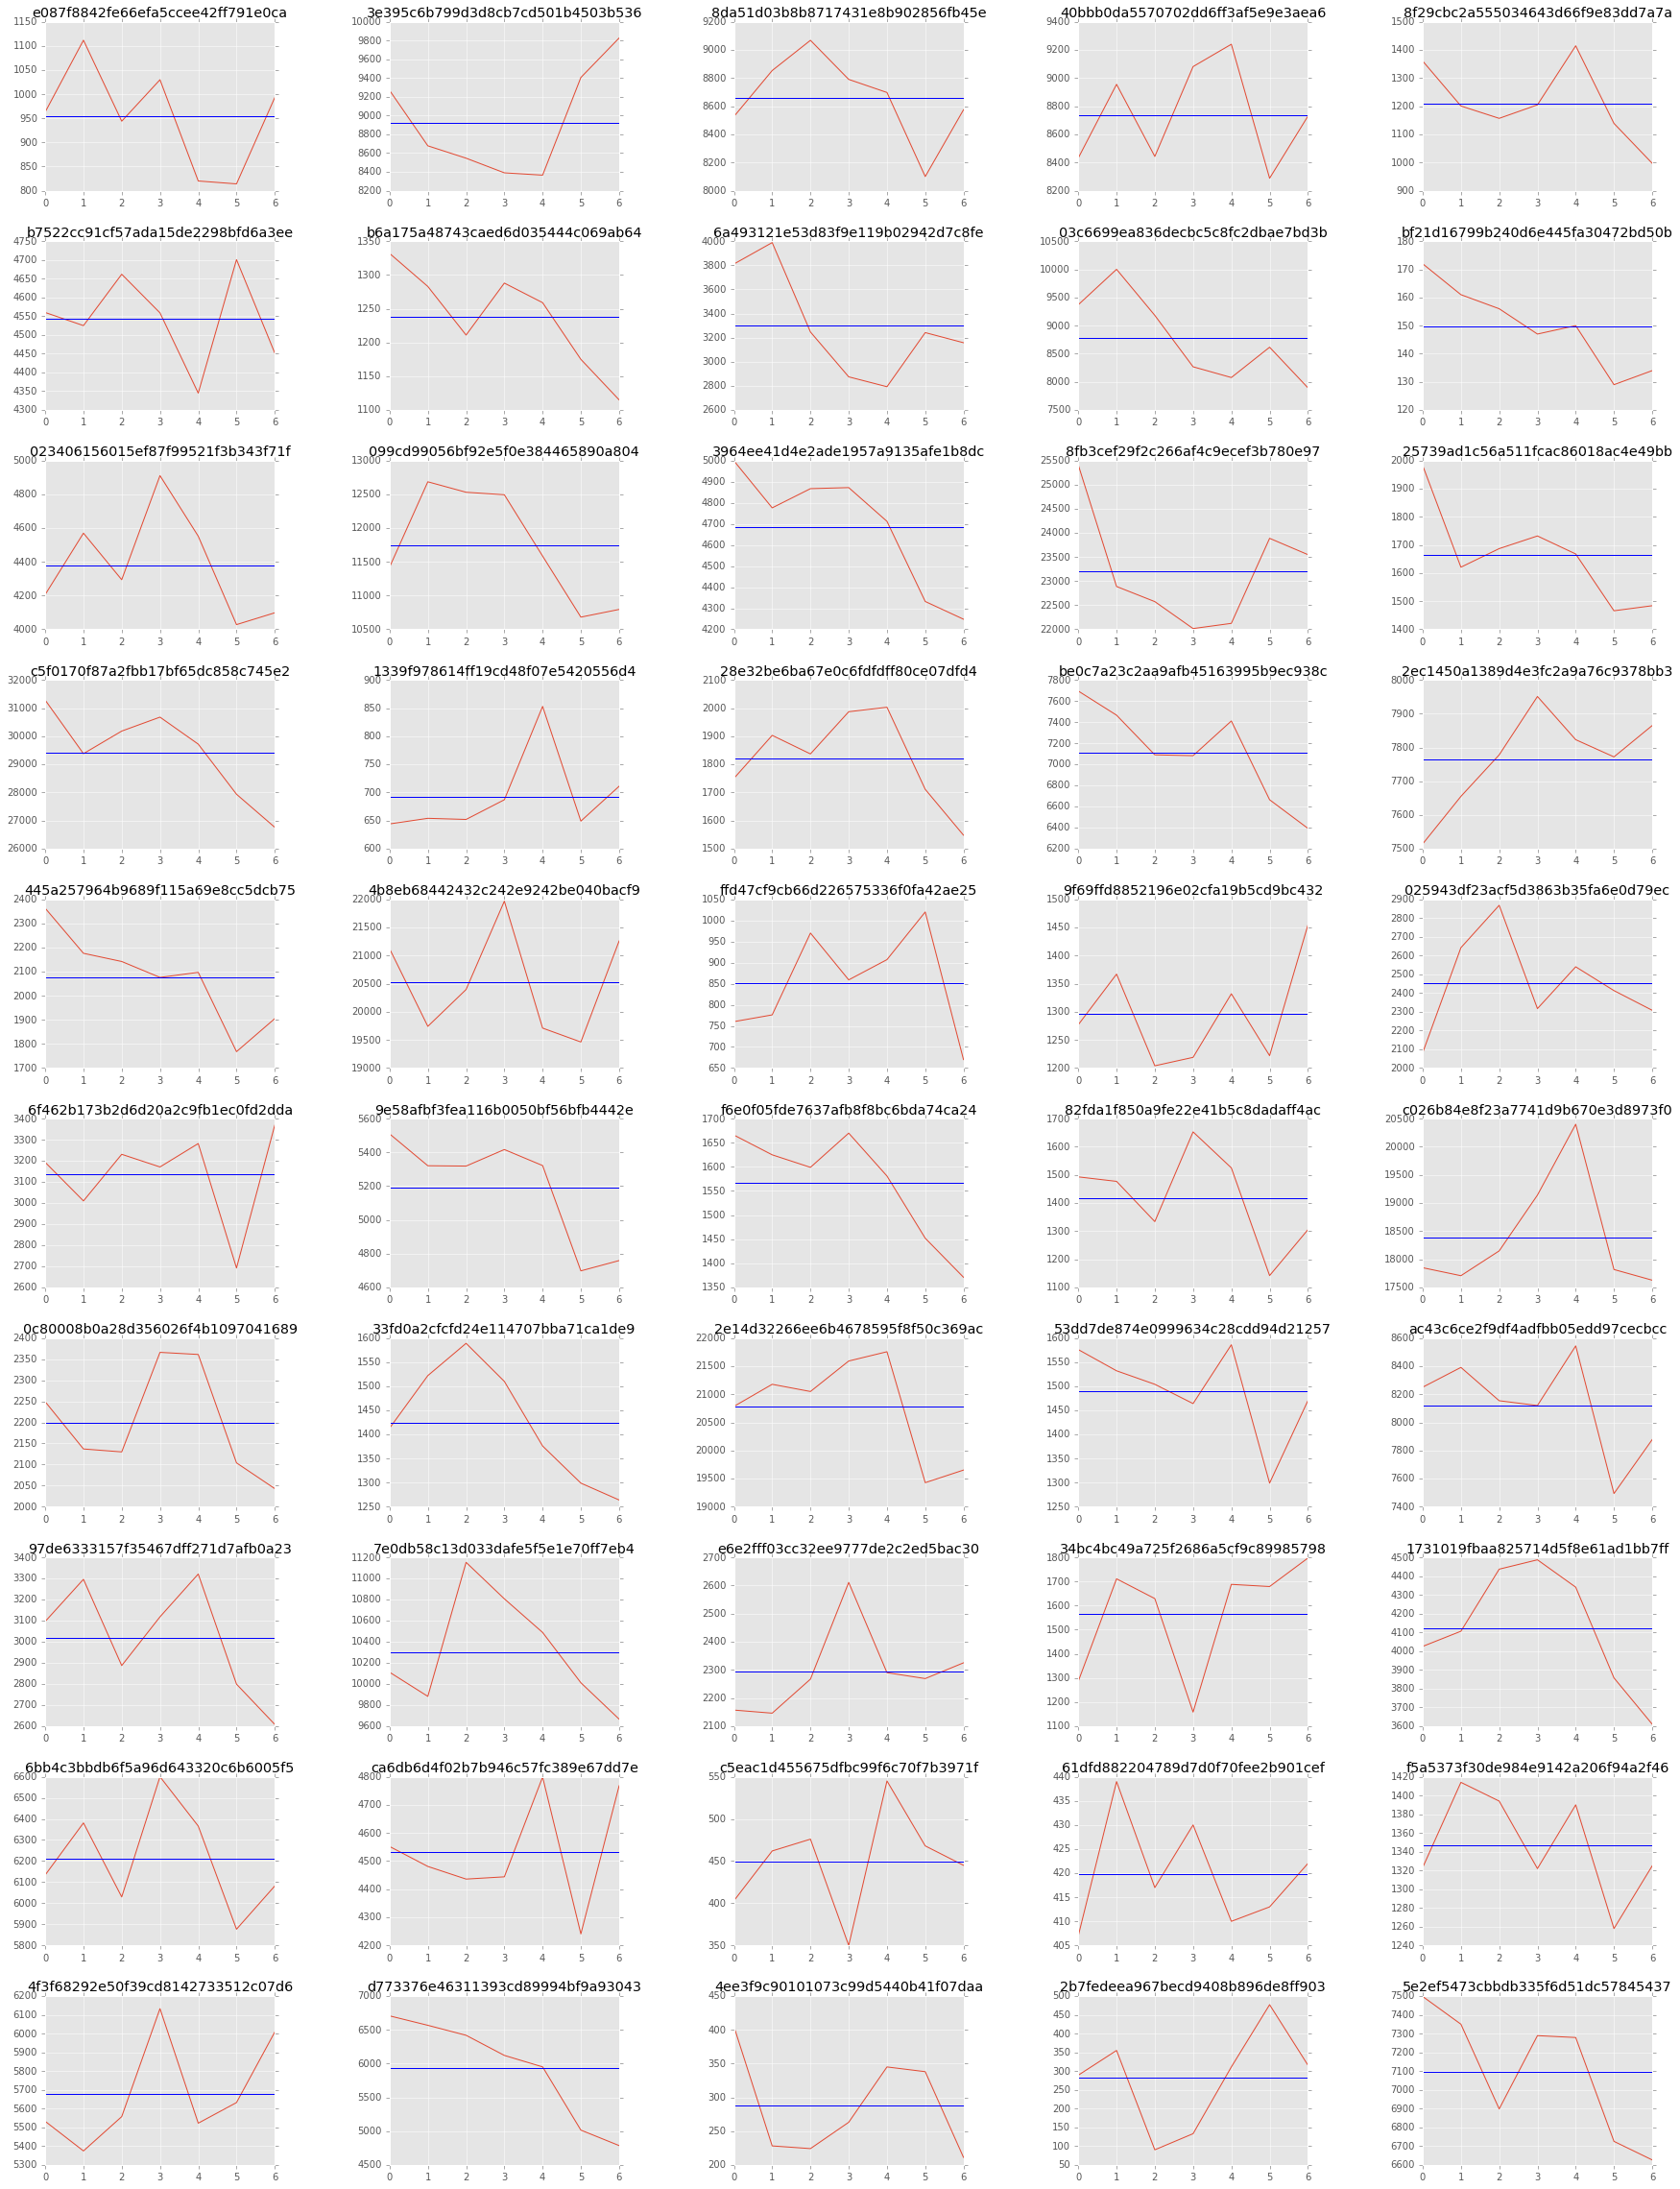

In [7]:
fig = plt.figure(figsize = (30, 40))
i = 1
trend = {}
for artist in data_w_day:
    trend[artist] = []
    ax = fig.add_subplot(10, 5, i)
    play = data_w_day[artist]
    df = pd.Series(data = play)
    df.plot(ax = ax, title = artist)
    avg = df.mean()
#     print avg
    ax.axhline(avg)
    
    for j in range(0,7):
        trend[artist].append((df.iloc[j] - avg)/avg)
    
    i+=1
plt.subplots_adjust(wspace = 0.5, hspace = 0.3)
# fig.savefig('image/w_day_artist.png')

In [8]:
trend

{'023406156015ef87f99521f3b343f71f': [-0.039694706285267028,
  0.043413027169835874,
  -0.019602726768648743,
  0.12126944779673172,
  0.039303304086891228,
  -0.080335301216608548,
  -0.064353044782934923],
 '025943df23acf5d3863b35fa6e0d79ec': [-0.15155221620362283,
  0.077173976352728726,
  0.16931679189236412,
  -0.055332284932145169,
  0.035587395887937537,
  -0.016191973906459343,
  -0.059001689090803215],
 '03c6699ea836decbc5c8fc2dbae7bd3b': [0.068181078000325648,
  0.13999348640286594,
  0.046637355479563561,
  -0.057547630679042526,
  -0.079319329099495225,
  -0.017879824132877409,
  -0.1000651359713402],
 '099cd99056bf92e5f0e384465890a804': [-0.027325927998734706,
  0.080408307276775365,
  0.067207669752898644,
  0.0640565498278442,
  -0.013358801844439329,
  -0.090348326499823606,
  -0.080639470514520722],
 '0c80008b0a28d356026f4b1097041689': [0.022936972059779136,
  -0.028005198180636719,
  -0.031189083820662711,
  0.076153346328784982,
  0.073879142300194989,
  -0.043014944

8天平均，再加上星期的趋势做扰动

In [17]:
dates = pd.date_range('20150901', '20151030')
for artist in artist_id:
    data = df_song_by_artist[df_song_by_artist['artist_id'] == artist][-8:]
    data_mean = data.mean(axis = 0)
    data_mean_play = data_mean['play']
    data_week = []
    for i in range(0, 7):
        data_week.append(int(data_mean_play * (1 + trend[artist][i]*0.5)))
#     print data_mean_play, data_week
    count = 0
    week_day = 1
    data_temp = []
    while count < 60:
        week_day = week_day % 7
        data_temp.append(data_week[week_day])
        week_day += 1
        count += 1
    
    temp = pd.DataFrame(data={'artist_id':artist, 'play':data_temp}, index=dates)
    temp['date']=dates
    temp.to_csv('./output/mean_by_artist_august_last8days_plus_week_trend.csv', mode = 'a', encoding='utf-8',
                date_format = "%Y%m%d", index = False,header = False)

- 统计所有歌手，每星期的播放数据

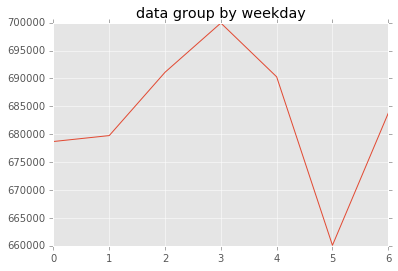

In [75]:
# 将之前每个歌手的星期播放数据相加
play_sum = [0,0,0,0,0,0,0]
for artist in data_w_day:
    play = data_w_day[artist]
    for j in range(0, 7):
        play_sum[j] += play[j]
# 输出图像
pd.Series(data = play_sum).plot(title = "data group by weekday")

- 单个歌手，统计所有星期的曲线叠加

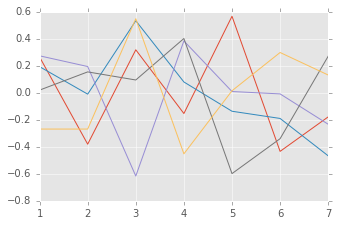

In [4]:
period = 42
fig = plt.figure(figsize = (30, 40))
plot_id = 1
for artist in artist_id[:1]:
    ax = fig.add_subplot(10, 5, plot_id)
    data_artist = df_song_by_artist[df_song_by_artist.artist_id == artist]
    for day in range(1, 183, period):
        j = day
        play_period = pd.Series(data=[0, 0, 0, 0, 0, 0, 0], index = [i for i in range(1,8)])
        while j < (day+period-1) and j < 183:
            data_week = data_artist.iloc[range(j, j+7)]
            data_week = data_week.set_index(['w_day'])['play']
            
            play_period = play_period + data_week       
#             print 'data_week', data_week
#             print 'j: ', j
            j += 7
        
        play_period = play_period.apply(lambda x : (x - np.mean(play_period)) / (np.max(play_period) - np.min(play_period)))
#         print 'play_period', play_period
        play_period.plot(ax = ax)
    plot_id += 1

**把8月最后8天、7天、6天数据做平均的结果比较**

In [65]:
df_mean_8 = pd.read_csv('./output/mean_by_artist_august_last8days.csv', 
                         header = None, 
                         names = ('artist_id', 'play', 'date'))
df_mean_7 = pd.read_csv('./output/mean_by_artist_august_last7days.csv', 
                         header = None, 
                         names = ('artist_id', 'play', 'date'))
df_mean_6 = pd.read_csv('./output/mean_by_artist_august_last6days.csv', 
                         header = None, 
                         names = ('artist_id', 'play', 'date'))

df_mean_8 = df_mean_8.iloc[[i for i in range(0, 3000, 60)]]
df_mean_7 = df_mean_7.iloc[[i for i in range(0, 3000, 60)]]
df_mean_6 = df_mean_6.iloc[[i for i in range(0, 3000, 60)]]

for i in range(0, 50):
    if df_mean_6.iloc[i]['artist_id'] != df_mean_7.iloc[i]['artist_id']:
        print 'not match in 6&7 :', i
    if df_mean_7.iloc[i]['artist_id'] != df_mean_8.iloc[i]['artist_id']:
        print 'not match in 7&8 :', i

df_67 = df_mean_6['play'] - df_mean_7['play']
df_68 = df_mean_6['play'] - df_mean_8['play']
df_78 = df_mean_7['play'] - df_mean_8['play']

In [66]:
play_abs_67 = []
for i in range(0, 50):
    temp = df_67.iloc[i]
    if temp > 0:
        play_abs_67.append(1)
    elif temp == 0:
        play_abs_67.append(0)
    elif temp < 0:
        play_abs_67.append(-1)
play_abs_67 = pd.Series(data = play_abs_67)

play_abs_68 = []
for i in range(0, 50):
    temp = df_68.iloc[i]
    if temp > 0:
        play_abs_68.append(1)
    elif temp == 0:
        play_abs_68.append(0)
    elif temp < 0:
        play_abs_68.append(-1)
play_abs_68 = pd.Series(data = play_abs_68)

play_abs_78 = []
for i in range(0, 50):
    temp = df_78.iloc[i]
    if temp > 0:
        play_abs_78.append(1)
    elif temp == 0:
        play_abs_78.append(0)
    elif temp < 0:
        play_abs_78.append(-1)
play_abs_78 = pd.Series(data = play_abs_78)

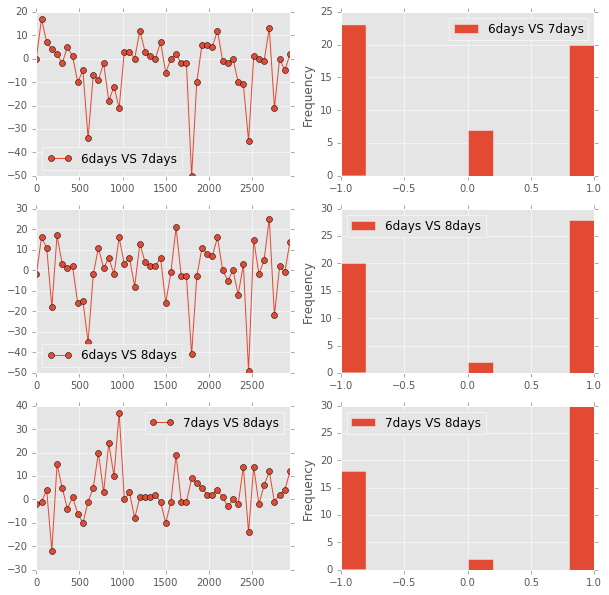

In [69]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(3,2,1)
df_67.plot(ax = ax, label = '6days VS 7days', legend = True, marker = 'o')
ax = fig.add_subplot(3,2,2)
play_abs_67.plot(kind = 'hist', ax = ax, label = '6days VS 7days', legend = True)
ax = fig.add_subplot(3,2,3)
df_68.plot(ax = ax, label = '6days VS 8days', legend = True, marker = 'o')
ax = fig.add_subplot(3,2,4)
play_abs_68.plot(kind = 'hist', ax = ax, label = '6days VS 8days', legend = True)
ax = fig.add_subplot(3,2,5)
df_78.plot(ax = ax, label = '7days VS 8days', legend = True, marker = 'o')
ax = fig.add_subplot(3,2,6)
play_abs_78.plot(kind = 'hist', ax = ax, label = '7days VS 8days', legend = True)

** 将一首歌曲按照天分开，统计逐小时的播放量 **

- 为user_action表添加小时数据段

使用dataframe的apply方法，对一个Series进行操作，应用自定义的函数获取小时字段

In [6]:
def get_hour(time_value):
    time_value = time.localtime(time_value)
    return time_value.tm_hour

def get_wday(time_value):
    time_value = time.localtime(time_value)
    return time_value.tm_wday+1

In [7]:
df_user_actions['hour'] = df_user_actions['gmt_create'].apply(get_hour)
df_user_actions['week_day'] = df_user_actions['gmt_create'].apply(get_wday)

- 对单首歌曲进行分析

选择歌曲“ecea5fe33e6817d09c395f2910479728”

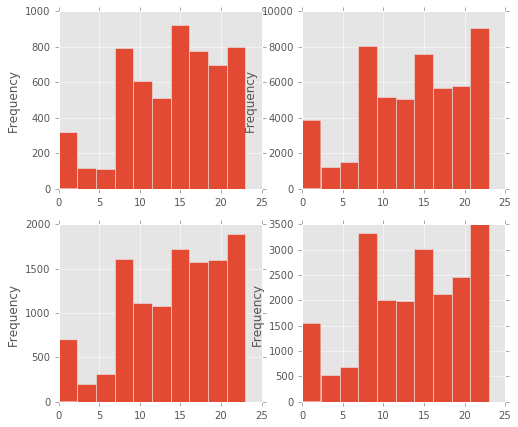

In [49]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(2, 2, 1)

df_user_actions[(df_user_actions.song_id == "ecea5fe33e6817d09c395f2910479728")
                                 & (df_user_actions.action_type == 1)]['hour'].plot.hist()

ax2 = fig.add_subplot(2, 2, 2)

df_user_actions[(df_user_actions.song_id == "8a27d9a6c59628c991c154e8d93f412e")
                                 & (df_user_actions.action_type == 1)]['hour'].plot.hist()

ax3 = fig.add_subplot(2, 2, 3)

df_user_actions[(df_user_actions.song_id == "31a3d0420d89c9b121bb55dbdbbeda6b")
                                 & (df_user_actions.action_type == 1)]['hour'].plot.hist()

ax4 = fig.add_subplot(2, 2, 4)

df_user_actions[(df_user_actions.song_id == "f87ff481d85d2f95335ab602f38a7655")
                                 & (df_user_actions.action_type == 1)]['hour'].plot.hist()

**分析周数据是否有规律**

- 分析每周是否有周期性规律，将同一个艺人的周数据叠加在同一张图上

**标注发片时间**

/home/yli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


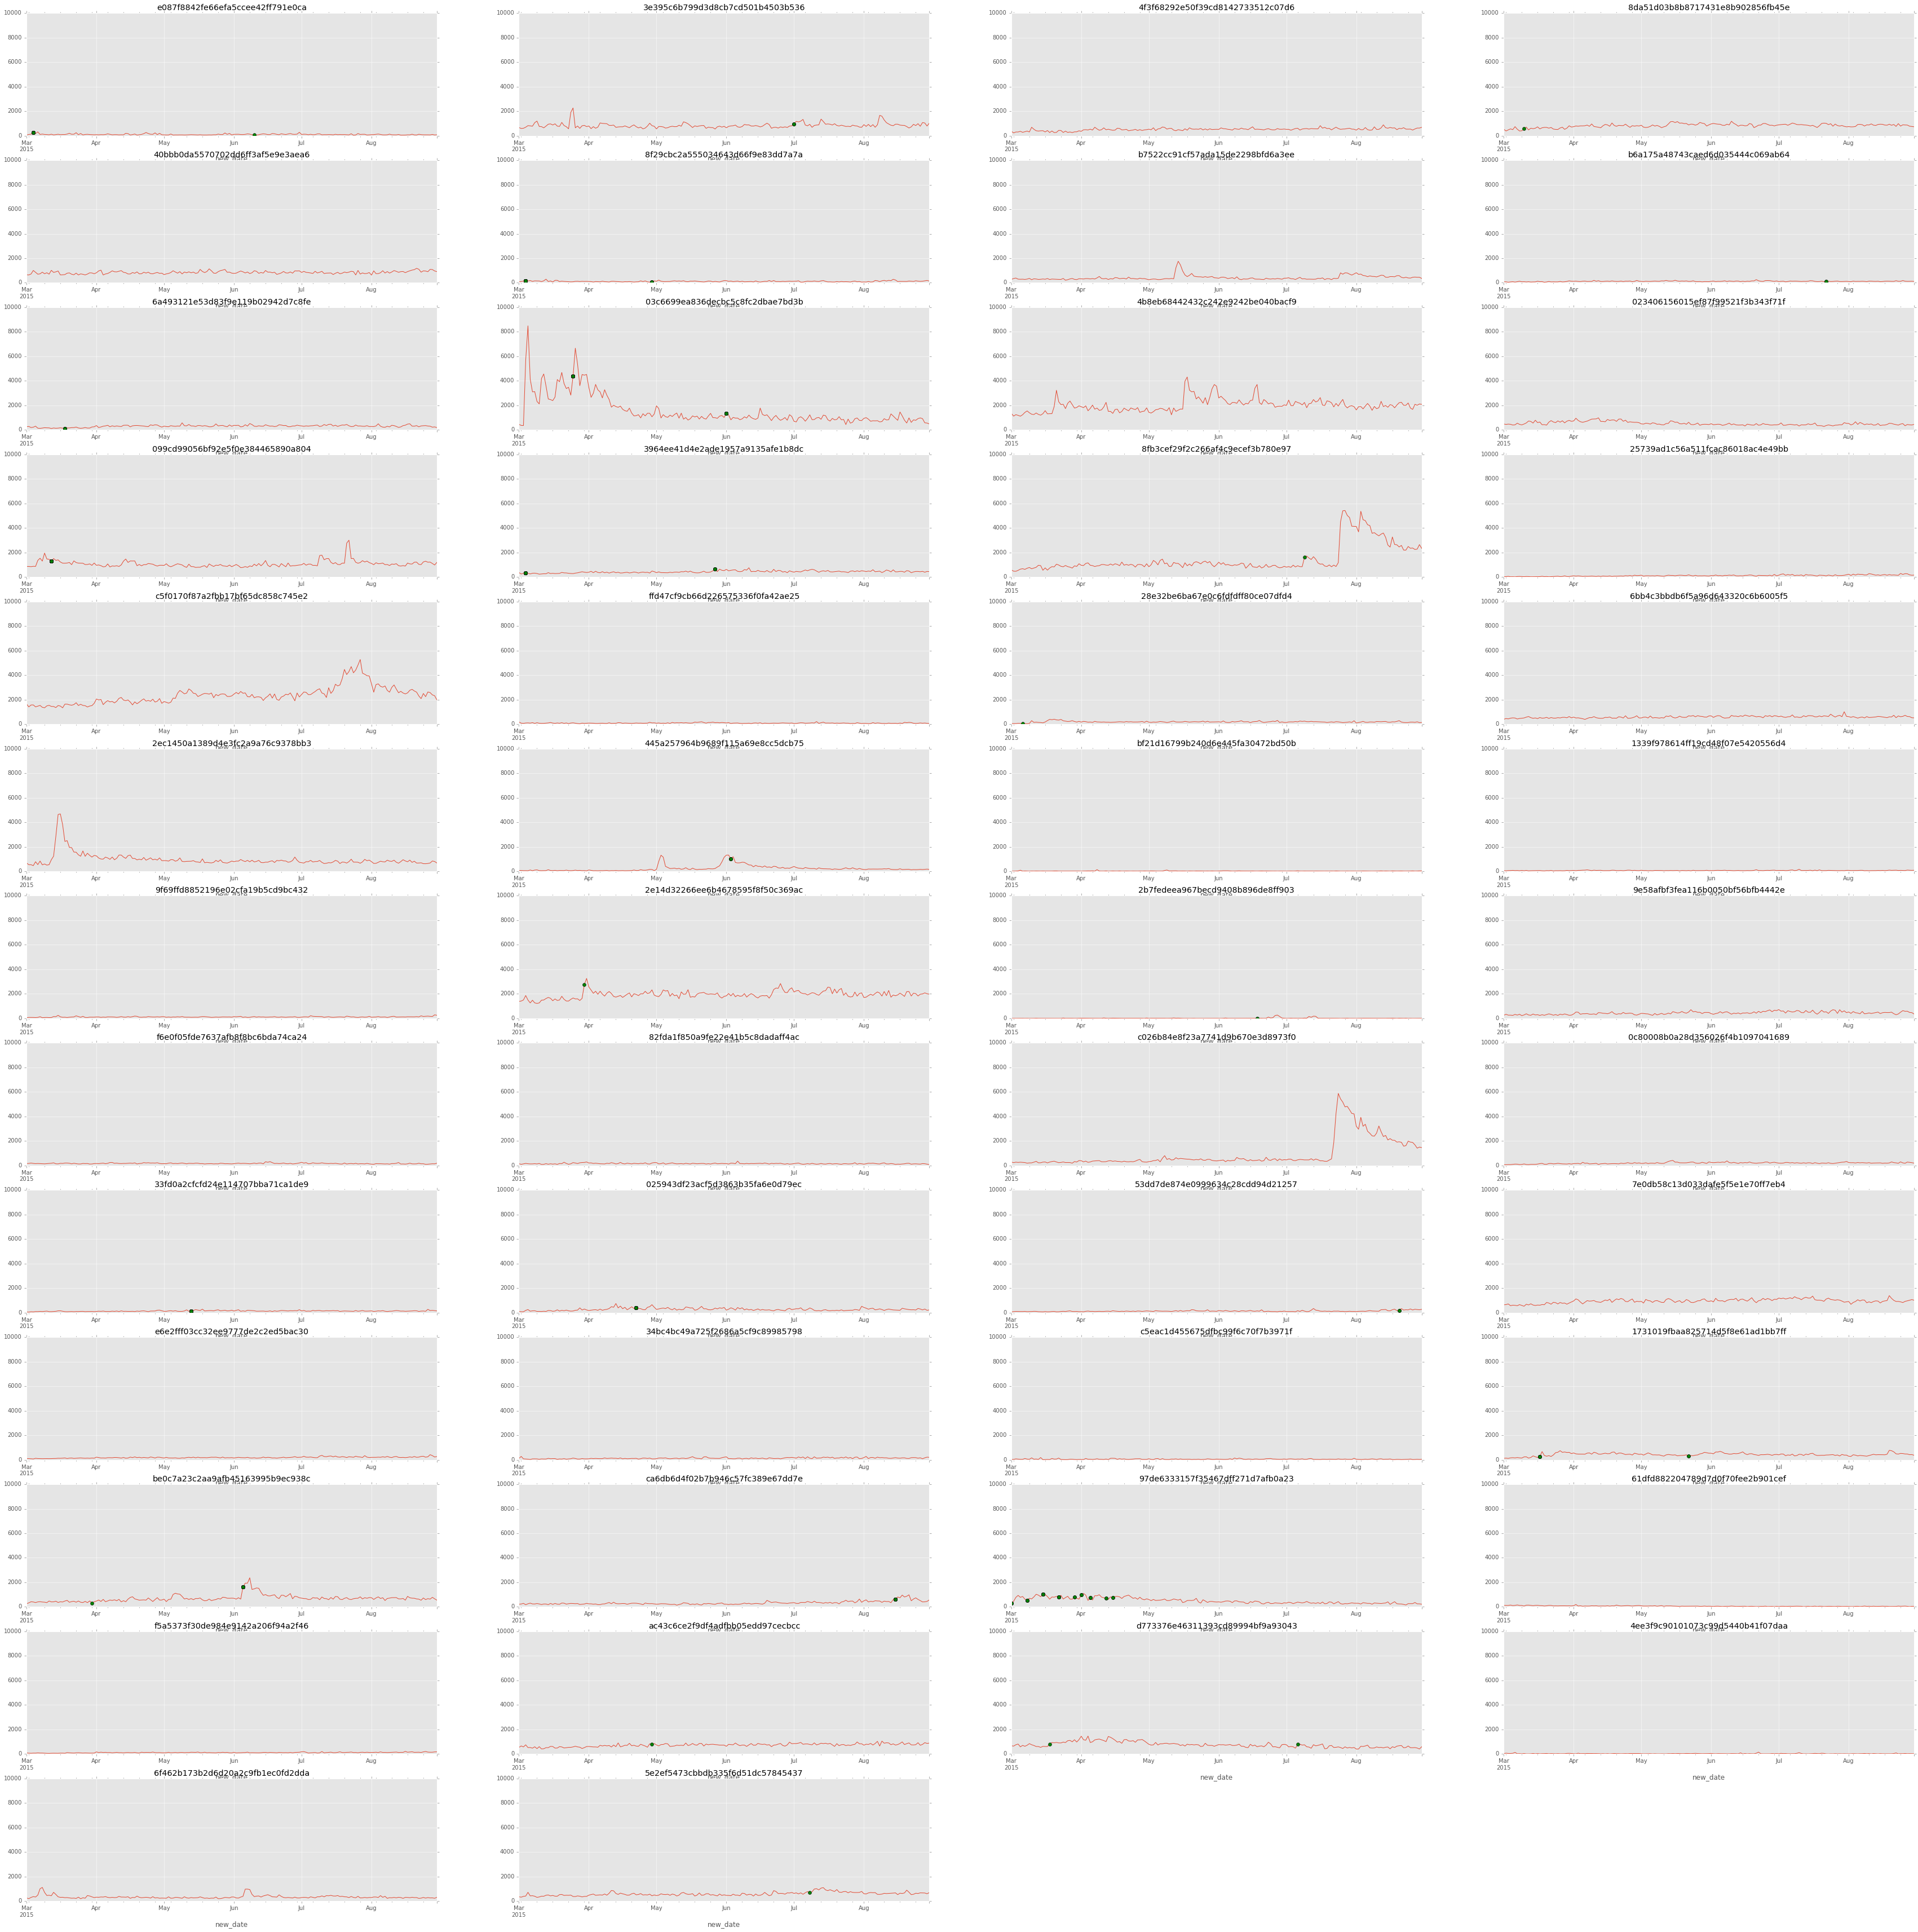

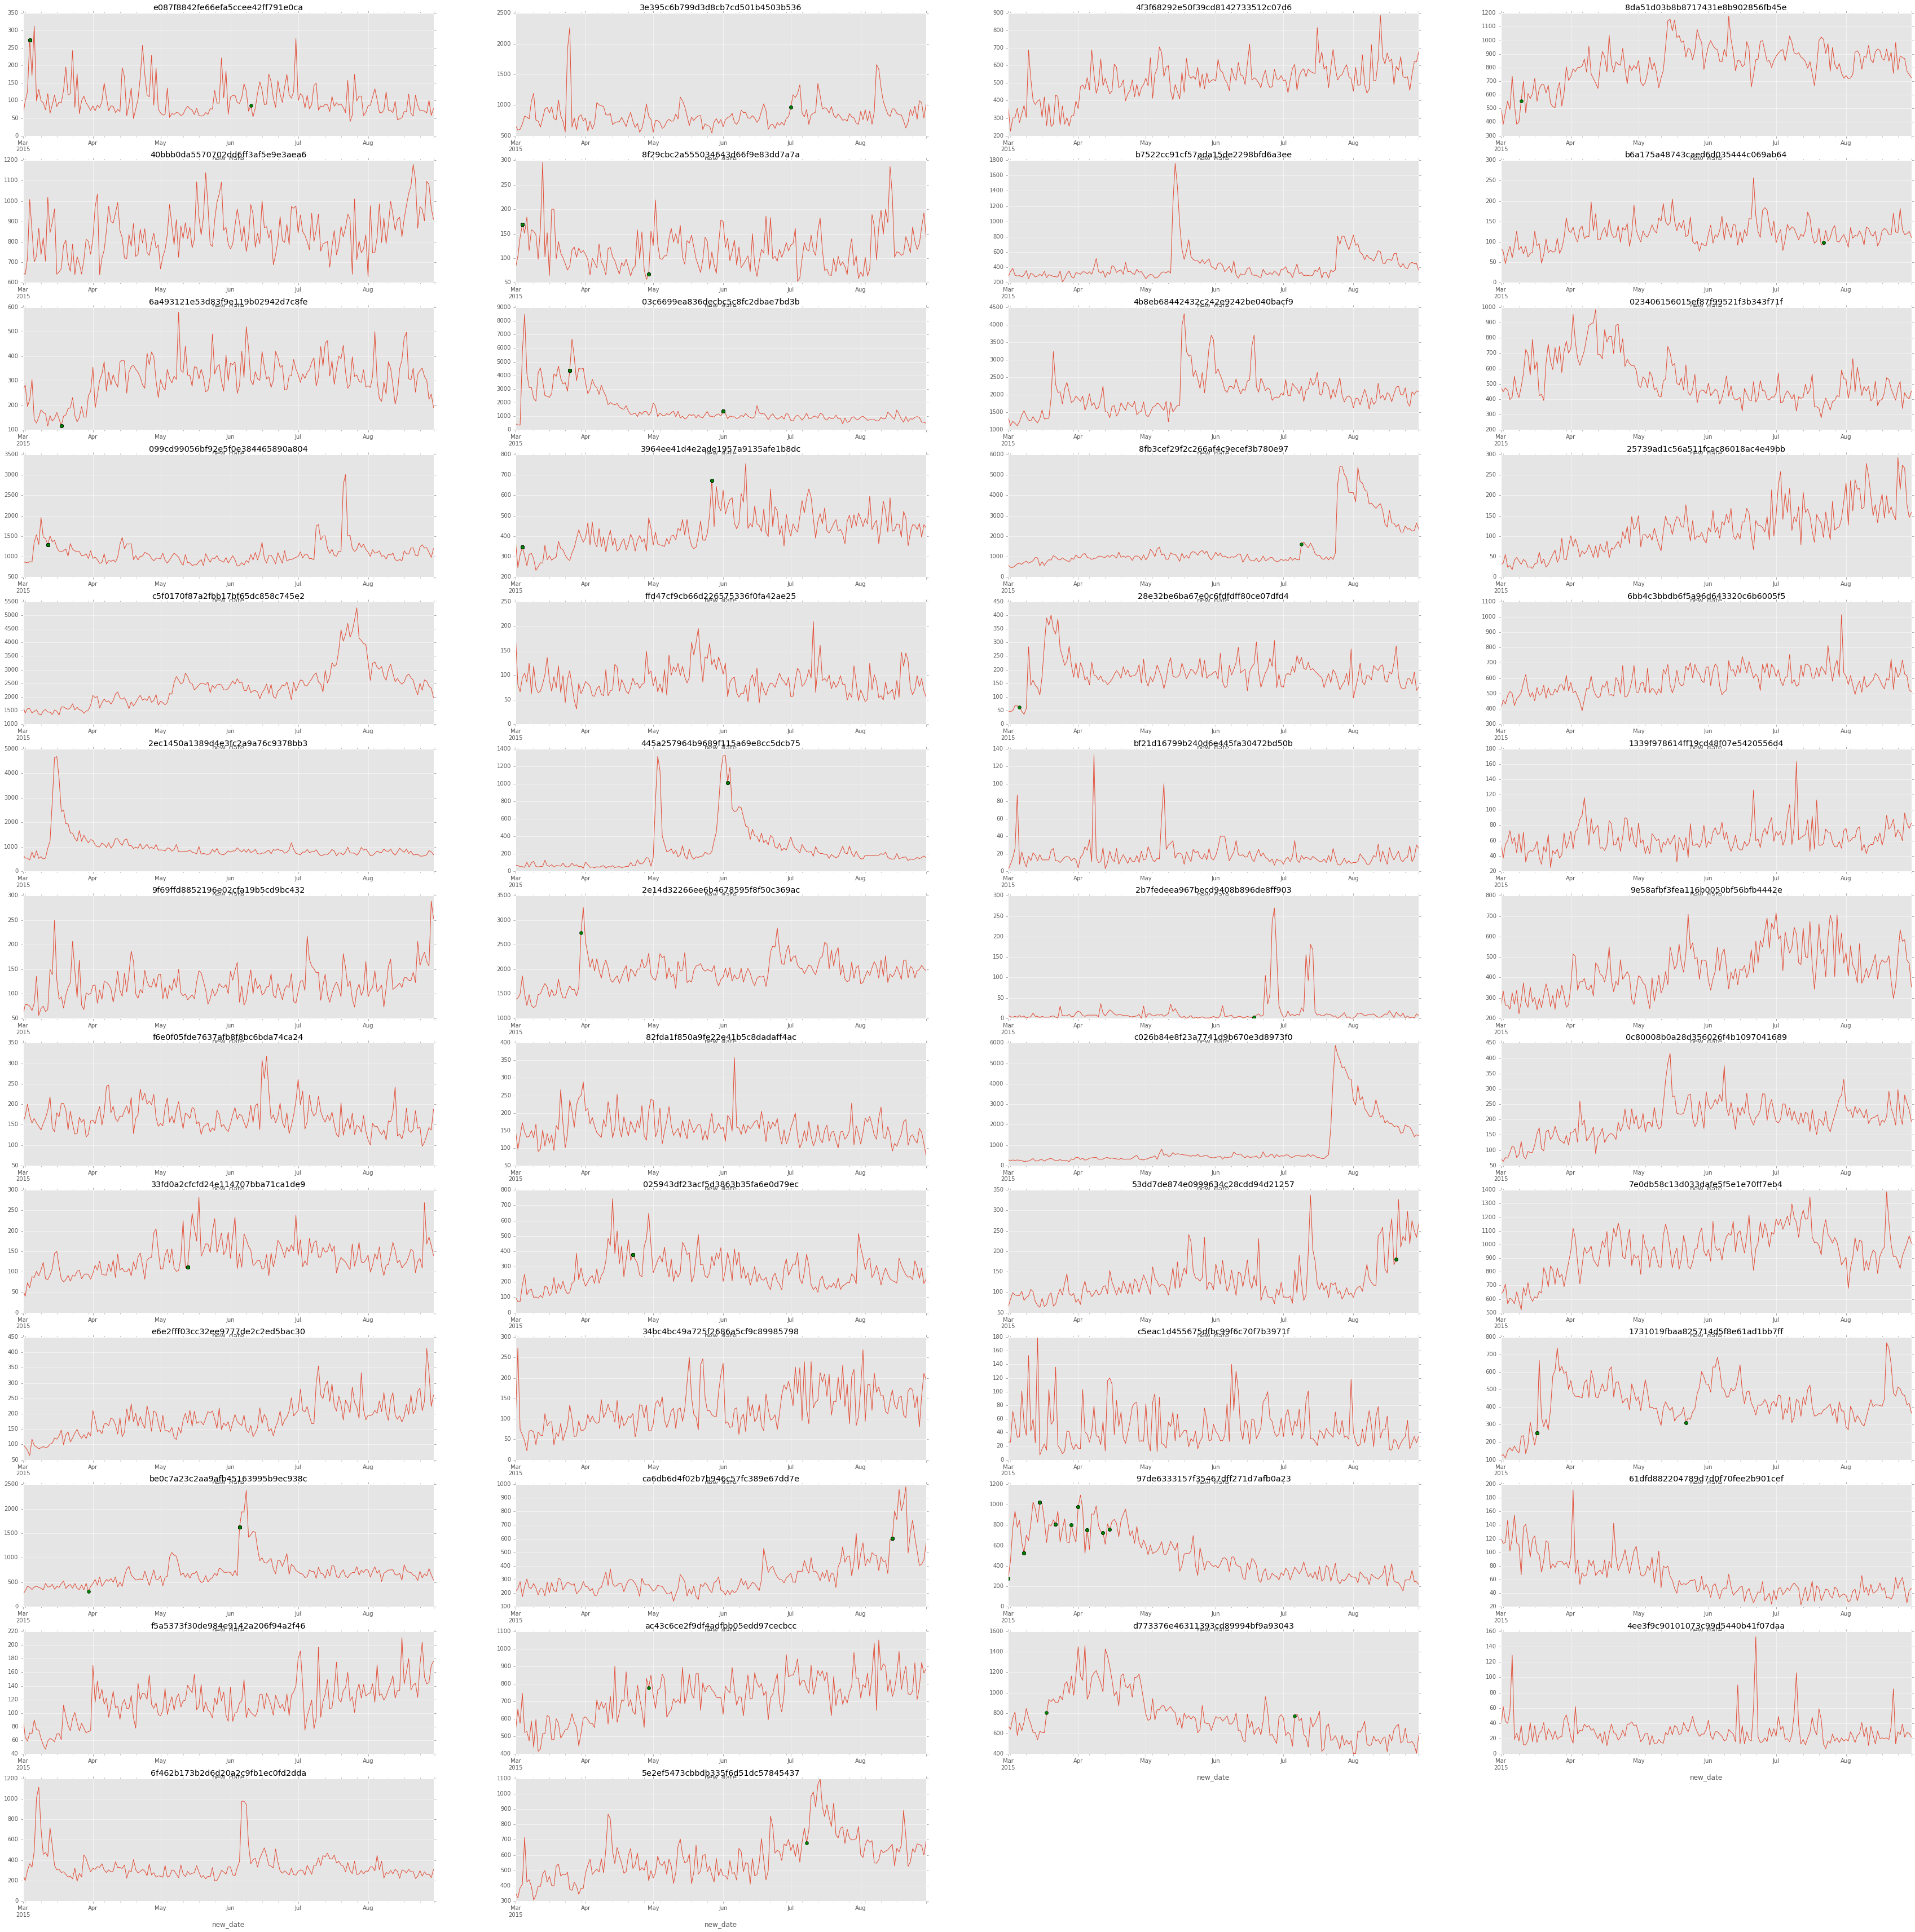

In [100]:
date_past = pd.date_range('20150301', '20150830')
fig1 = plt.figure(figsize = (60, 60))
fig2 = plt.figure(figsize = (60, 60))
i = 1
for artist in artist_id[:]:
    # 设定画布
#     fig = plt.figure()
    sub_ax1 = fig1.add_subplot(13, 4, i)
    sub_ax2 = fig2.add_subplot(13, 4, i)
    sub_ax1.set_ylim([0, 10000])
    sub_ax1.set_title(artist)
    sub_ax2.set_title(artist)
    # 提取艺人在3月到8月的发片记录
    pub_info = df_song_info[df_song_info.artist_id == artist]
    pub_info = pub_info[(pub_info.public_time >= 20150301) & (pub_info.public_time <= 20150830)]
    pub_info = pub_info['public_time'].sort_values(inplace = False, ascending = False)
    # 提取指定艺人的数据
    temp = df_song_by_artist[df_song_by_artist.artist_id == artist]
    temp['new_date'] = date_past.tolist()
    temp = temp.set_index(['new_date'])
    temp['play'].plot(ax = sub_ax1)
    temp['play'].plot(ax = sub_ax2)
    for pub_date in pub_info:
        the_data = temp[temp.date == pub_date]['play']
        the_data.plot(ax = sub_ax1, color = 'green', marker = 'o')
        the_data.plot(ax = sub_ax2, color = 'green', marker = 'o')
#     sub_ax.figure.savefig('image/public&play_artist'+str(i)+'.png')
    # 增加画布序号
    i += 1
fig1.savefig('./image/1.jpg')
fig2.savefig('./image/2.jpg')

**统计播放量和下载量的相关性**

In [2]:
# artist_V = ['8fb3cef29f2c266af4c9ecef3b780e97', 'c026b84e8f23a7741d9b670e3d8973f0',
#             'c5f0170f87a2fbb17bf65dc858c745e2', '03c6699ea836decbc5c8fc2dbae7bd3b', 
#             '4b8eb68442432c242e9242be040bacf9', '2e14d32266ee6b4678595f8f50c369ac']

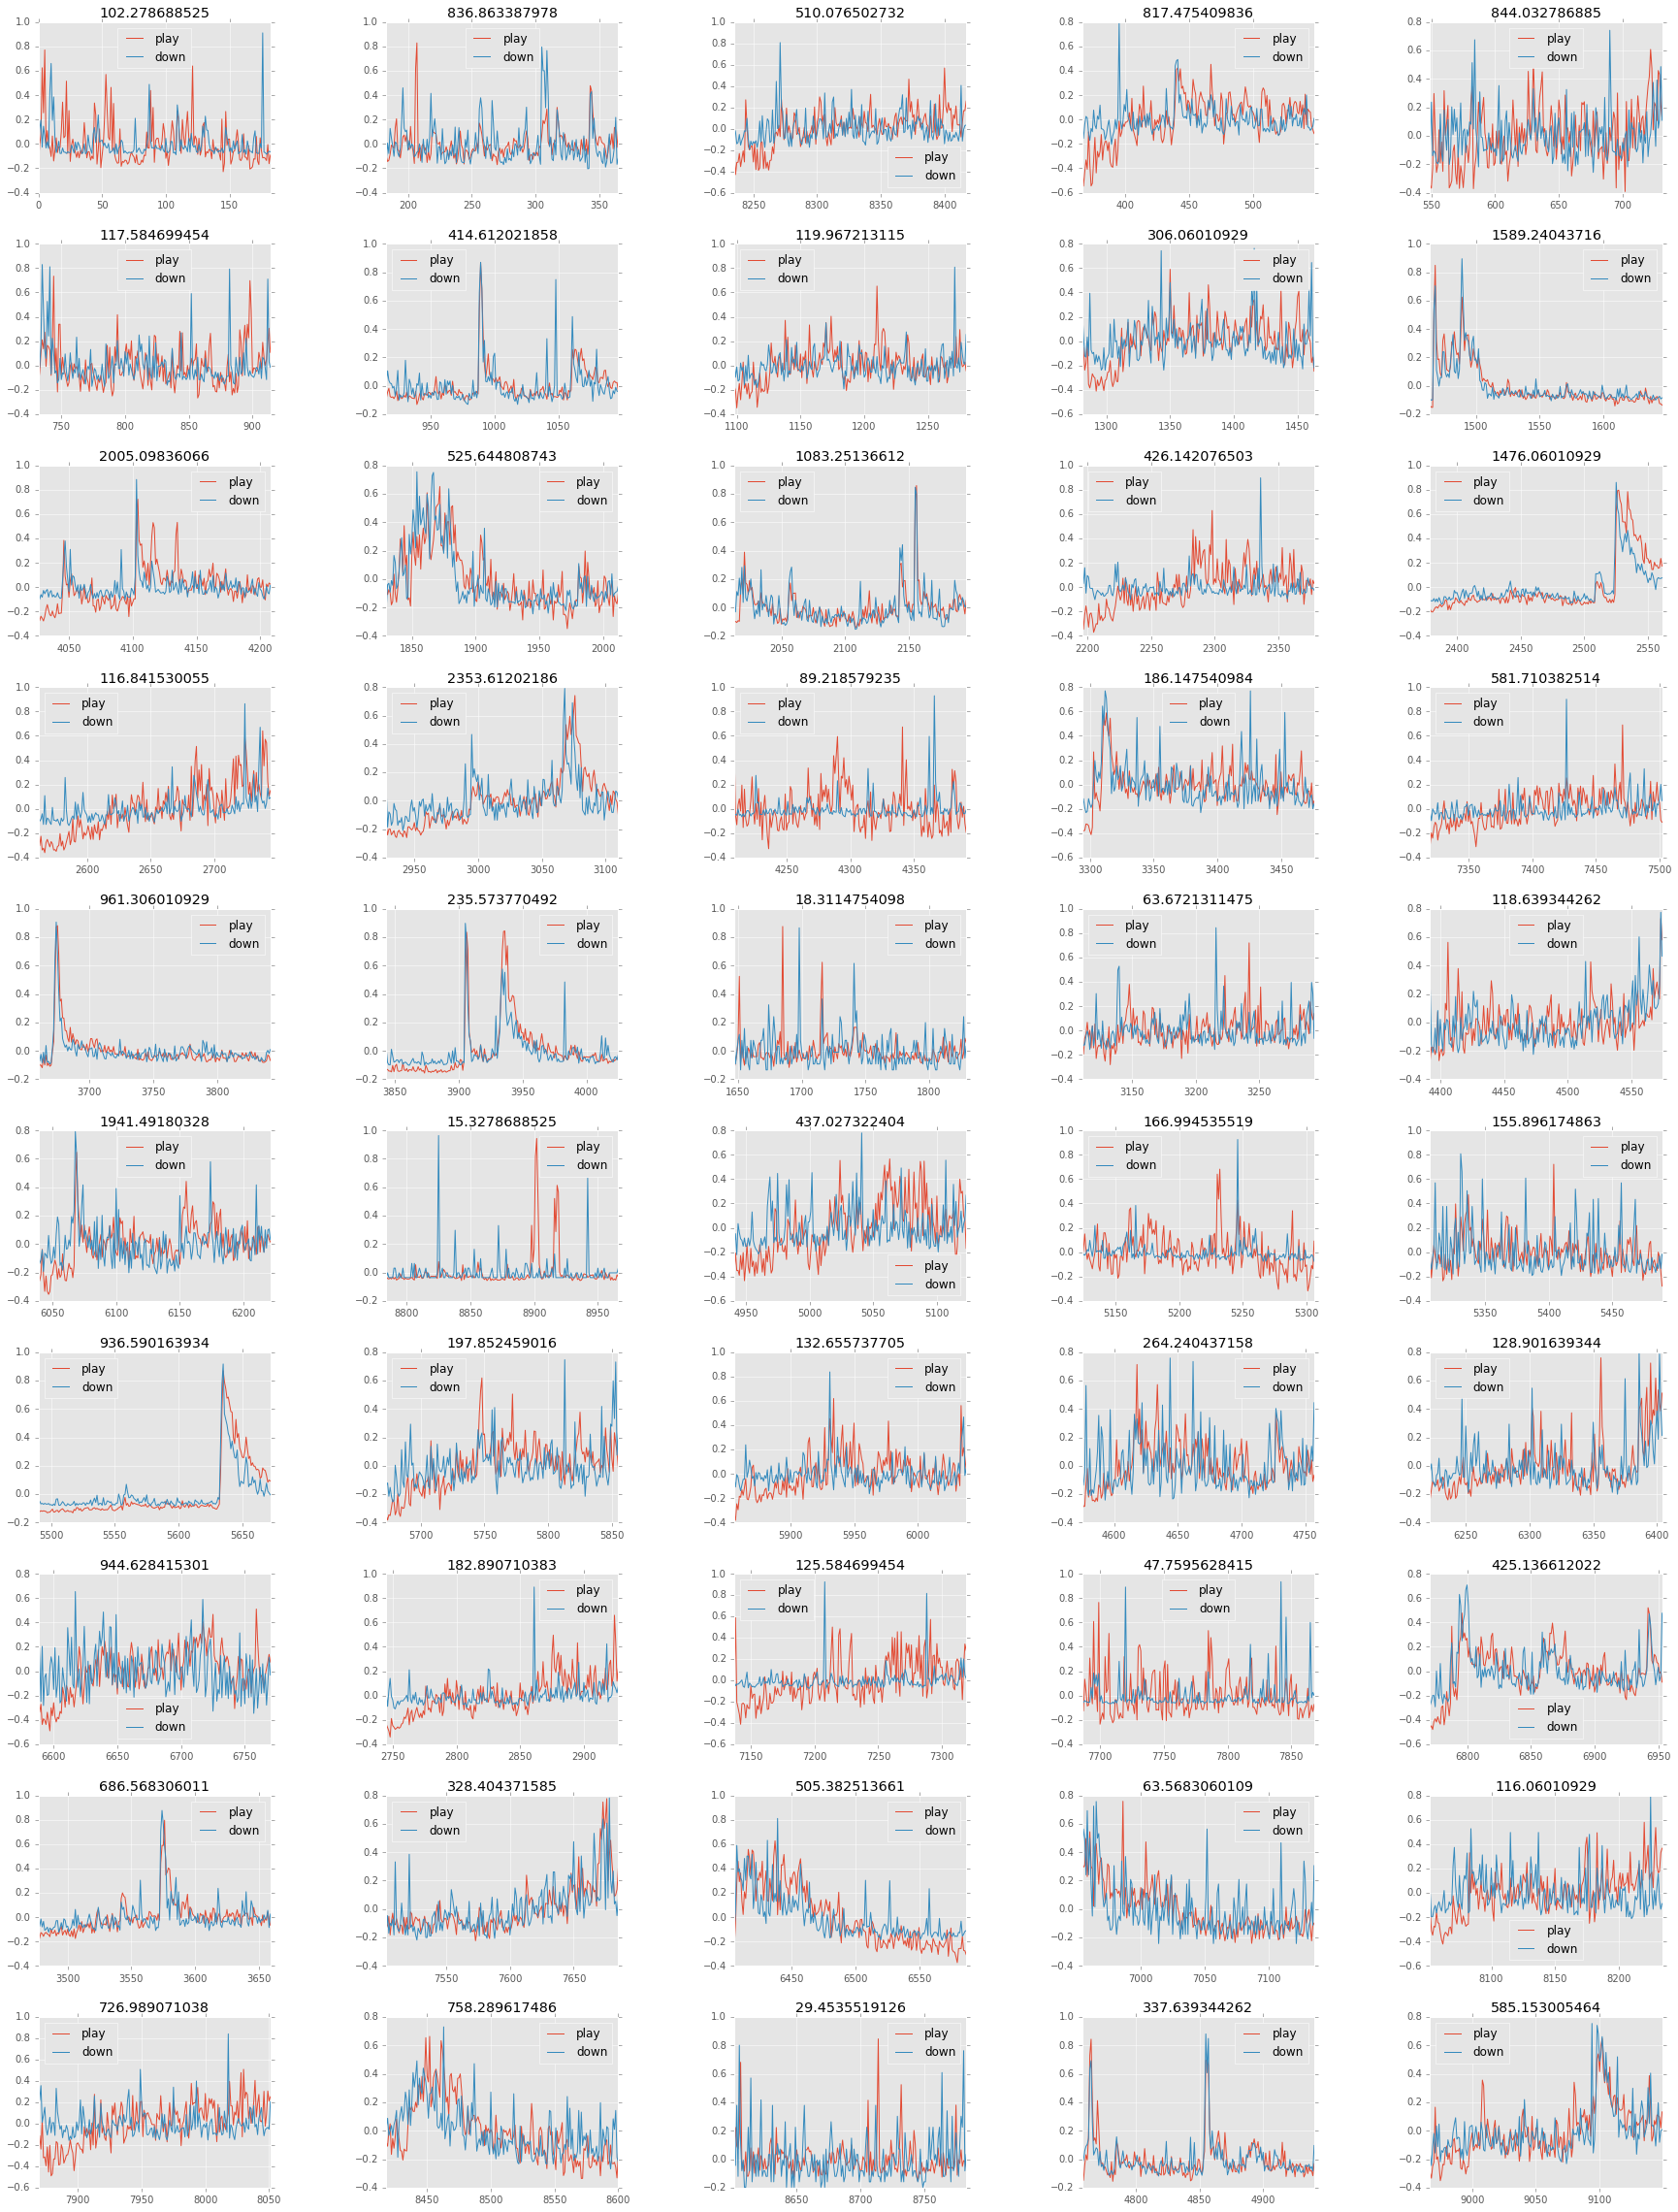

In [13]:
fig = plt.figure(figsize = (30, 40))
i = 1
for artist in artist_id:
    ax = fig.add_subplot(10, 5, i)
    temp = df_song_by_artist[df_song_by_artist.artist_id == artist]
    data_play = temp.play.apply(lambda x : (x - np.mean(temp.play)) / (np.max(temp.play) - np.min(temp.play)))
    data_play.plot(ax = ax, label = 'play', legend = True)
    data_down = temp.download.apply(lambda x : (x - np.mean(temp.download)) / (np.max(temp.download) - np.min(temp.download)))
    data_down.plot(ax = ax, label = 'down', legend = True)
    ax.set_title(np.mean(temp.play))
    
    i+=1
plt.subplots_adjust(wspace = 0.5, hspace = 0.3)
fig.savefig('image/song_artist_play_down.png')

**对单个歌手的歌曲进行聚类划分**

In [14]:
play = df_song_by_artist[df_song_by_artist.artist_id == '8fb3cef29f2c266af4c9ecef3b780e97']
info = df_song_info[df_song_info.artist_id == '8fb3cef29f2c266af4c9ecef3b780e97']

In [15]:
len(info)

22